# Transformers

## Setup 

This code is adapted from Fastai NLP course. For more info on their course, please visit: https://www.fast.ai/2019/07/08/fastai-nlp/ and https://github.com/fastai/course-nlp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 82.3 MB/s 
     |████████████████████████████████| 188 kB 66.0 MB/s 
     |████████████████████████████████| 60 kB 8.1 MB/s 
Mounted at /content/gdrive


In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 5.0 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143860 sha256=256ed898dd06cb2d2eaacba036afc50457ef3de2a9d0ce239cc367a369f68de2
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
from fastai.text import *

In [ ]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 23 19:36:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.device(0)
torch.cuda.get_device_name(0)


'Tesla V100-SXM2-16GB'

In [ ]:
!apt-get install htop 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
Suggested packages:
  strace
The following NEW packages will be installed:
  htop
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 80.0 kB of archives.
After this operation, 221 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 htop amd64 2.1.0-3 [80.0 kB]
Fetched 80.0 kB in 0s (208 kB/s)
Selecting previously unselected package htop.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../htop_2.1.0-3_amd64.deb ...
Unpacking htop (2.1.0-3) ...
Setting up htop (2.1.0-3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for mime-support (3.60ubuntu1) ...


In [ ]:
%cd drive/MyDrive/offline/Github/en_id_translation/

/content/drive/MyDrive/offline/Github/en_id_translation


In [ ]:
!ls

Attention.ipynb		     register_data_hugging_face.ipynb
fine_tune_en_id.ipynb	     RNNs.ipynb
fine_tune_model_id_en.ipynb  seq2seq.py
initialized_repo.ipynb	     transformer_en_id.ipynb
__pycache__		     transformer.ipynb
random_samples_RNNs.ipynb


## Code to re-run from start 

In [ ]:
path = '../../Data/nlp2/en-id.txt/'

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(path + 'random_sample.csv')
df.head()

,en,id
0,"Pretty lucky, huh?","Sungguh beruntung, huh?"
1,Tell me you've taken care of it.,Katakan kau sudah mengurusnya.
2,"Coffee, Mrs. Swann?","Kopi, Ny. Swann?"
3,All you have to do is look at pictures of her ...,Yang harus kau lakukan adalah melihat gambar-n...
4,"Oh, Jesus!","Oh, Yesus!"


In [ ]:
df.iloc[2500]

en     Look familiar?
id    sudah terbiasa?
Name: 2500, dtype: object

In [ ]:
from seq2seq import *

In [ ]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
  "Function that collect samples and adds padding. Flips token order if needed"
  samples = to_data(samples)
  max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
  res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
  res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
  if backwards: pad_first = not pad_first
  for i,s in enumerate(samples):
    if pad_first:
      res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
    else:
      res_x[i, :len(s[0]):], res_y[i, :len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
  if backwards: res_x, res_y = res_x.flip(1), res_y.flip(1)
  return res_x, res_y

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
  "Create a `TextDataBunch` suitable for training an RNN classifer."
  @classmethod
  def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs=None, pad_idx=1,
             dl_tfms=None, pad_first=False, device:torch.device=torch.cuda.device(0), no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
    "Function that transform the `datasets` in a `DataBunch` for classification. Passes **dl_kwargs` on to `DataLoader()`"
    datasets = cls._init_ds(train_ds, valid_ds, test_ds)
    val_bs = ifnone(val_bs, bs)
    collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
    train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
    train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
    dataloaders = [train_dl]
    for ds in datasets[1:]:
      lengths =[len(t) for t in ds.x.items]
      sampler = SortSampler(ds.x, key=lengths.__getitem__)
      dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
    return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [ ]:
class Seq2SeqTextList(TextList):
  _bunch = Seq2SeqDataBunch
  _label_cls = TextList

In [ ]:
src = Seq2SeqTextList.from_df(df, path=path, cols='id').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)
src = src.filter_by_func(lambda x,y: len(x) > 15 or len(y) > 15)
len(src.train) + len(src.valid)
data = src.databunch()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data.show_batch() 

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
"xxbos xxmaj jadi , dia datang kepadaku untuk xxunk xxmaj cinta ' xxmaj aku .","xxbos xxmaj so , he came to me for my love potion ."
"xxbos xxmaj perusahaan , yang tinggi , sempurna sebagai anak laki - laki ' !","xxbos xxmaj firm , high , perfect as boys ' !"
xxbos xxmaj ada sebuah desa di dekatnya . xxmaj aku akan menemukan sebuah perahu .,xxbos xxmaj there 's a village nearby . i 'll find a boat .
"xxbos xxmaj yeah , xxmaj aku tak ingin ada masalah . xxmaj terima kasih .","xxbos xxmaj yeah , i do n't want any trouble ."
xxbos xxmaj kita harus segera bertindak sebelum mereka yang bertindak lebih dulu pada kita .,xxbos xxmaj we have to come for them before they come for us .


In [ ]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [ ]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [ ]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [ ]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [ ]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb.cpu(),yb.cpu(),out.cpu()):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
data = load_data(path)

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
xxbos ini rumah dari xxunk yang bagi saya adalah orang yang agak terlupakan . mereka telah hilang cahayanya dalam sejarah buku oleh xxunk mereka xxunk orang yunani dan roma .,xxbos this was the home of the xxunk ... are a rather forgotten people . the greeks and the romans .
xxbos perusahaan asuransi jiwa new xxunk dan kehidupan yang merata di new york selama bertahun - xxunk melakukan bisnis yang cukup besar di antara orang - orang armenia .,xxbos the new york life insurance company and the xxunk life of new york have for years done considerable business among the xxunk .
xxbos kamu bilang joon - soo berpisah dengan korban sebelum jam 10 ya . / xxunk juga kamu tahu dari sana ke rumah waktu perlu waktu 5 xxunk ?,xxbos you joon - soo said goodbye to the victim before 10 ya . / xxunk also you know from there to the house when it takes 5 xxunk ?
"xxbos dan dalam hal itu akan mengatakan anda lebih baik tidak sialan main - main dengan saya atau laki - laki saya , kau mengerti ?","xxbos and in that will it says you better not fucking mess with me or my man , you understand me ?"
"xxbos / - aku tidak perduli dengan pikiranmu . ada warisan yang harus kulindungi , william , dan klub glee itu termasuk di dalamnya .","xxbos i have a legacy to protect , william , and glee club is a part of that legacy ."


## Transformers

We add a transformer to the dataloader that shifts the targwets right and adds padding at the beginning

In [ ]:
v = data.vocab

In [ ]:
v.stoi['xxpad']

1

In [ ]:
#data.vocab.textify([5, 10, 5, 7, 3, 21, 100, 8])
data.vocab.textify([2,  793,   13, 1449,   13, 1449,   13,    0, 4890,   13, 4890,   
                    13, 4890,   13,   55,  384,   21, 1307,   13, 1307,   13, 1307,   
                    13, 384,   34,   18,   23,  292,   31,   17])

'xxbos do - o - o - xxunk j - j - j - hanya duduk dan s - s - s - duduk dengan ini di bawah anda !'

In [ ]:
def shift_tfm(b):
  x,y = b
  y = F.pad(y, (1,0), value=1)
  return [x, y[:,:-1]], y[:, 1:]

In [ ]:
data.add_tfm(shift_tfm)

### Embeddings
The input and output embeddings are traditional PyTorch embeddings ( and we can use pretrained vectors if we want to).  The transformer model isn't a recurrent one, so it has no idea of the relative position of the words. To help with that, they had to the input embeddings a positional encoding which is a cosnine of a certain frequency:

In [ ]:
d = 30
torch.arange(0., d, 2.)/d

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333])

In [ ]:
class PositionalEncoding(nn.Module):
  "Encode the position with a sinusoid."
  def __init__(self, d):
    super().__init__()
    self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

  def forward(self, pos):
    inp = torch. ger(pos, self.freq)
    enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
    return enc

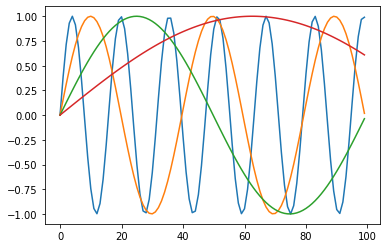

In [ ]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0, 100).float())
_, ax = plt.subplots(1, 1)
for i in range(1, 5): ax.plot(res[:, i])

In [ ]:
res[:6, :6]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578,  0.0631,  0.0251,  0.0100],
        [ 0.9093,  0.7147,  0.3117,  0.1259,  0.0502,  0.0200],
        [ 0.1411,  0.9300,  0.4578,  0.1882,  0.0753,  0.0300],
        [-0.7568,  0.9998,  0.5923,  0.2497,  0.1003,  0.0400],
        [-0.9589,  0.9132,  0.7121,  0.3103,  0.1253,  0.0500]])

In [ ]:
class TransformerEmbedding(nn.Module):
  "Embedding + posiitonal encoding + dropout"
  def __init__(self, vocab_sz, emb_sz, inp_p=0.):
    super().__init__()
    self.emb_sz = emb_sz
    self.embed = embedding(vocab_sz, emb_sz)
    self.pos_enc = PositionalEncoding(emb_sz)
    self.drop = nn.Dropout(inp_p)

  def forward(self, inp):
    pos = torch.arange(0, inp.size(1), device=inp.device).float()
    return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Feed Forward

The feed forward cell is just two linear layers with a skip connection and a LayerNorm

In [ ]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
  layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
  if double_drop: layers.append(nn.Dropout(ff_p))
  return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

### Multi-head attention

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True): 
    super().__init__()
    d_head = ifnone(d_head, d_model//n_heads)
    self.n_heads, self.d_head, self.scale = n_heads, d_head, scale
    self.q_wgt, self.k_wgt, self.v_wgt = [nn.Linear(
        d_model, n_heads * d_head, bias=bias) for o in range(3)]
    self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
    self.drop_att, self.drop_res = nn.Dropout(p), nn.Dropout(p) 
    self.ln = nn.LayerNorm(d_model)

  def forward(self, q, kv, mask=None):
    return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))

  def create_attn_mat(self, x, layer, bs):
    return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                         ).permute(0, 2, 1, 3)

  def _apply_attention(self, q, kv, mask=None): 
    bs, seq_len = q.size(0), q.size(1)
    wq, wk, wv = map(lambda o: self.create_attn_mat(*o, bs), 
                     zip((q, kv, kv), (self.q_wgt, self.k_wgt, self.v_wgt))) 
    attn_score = wq @ wk.transpose(2, 3)
    if self.scale: attn_score /= math.sqrt(self.d_head)
    if mask is not None:
      attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
    attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
    attn_vec = attn_prob @ wv
    return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1) 


### Masking 
The attention layer uses a mask to avoid paying attention to certain timesteps. The first thing is that we don't really want the network to pay attention to the padding, so we're going to mask it. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens we're not supposed to see yet. 

In [ ]:
def get_output_mask(inp, pad_idx=1):
  return torch.triu(inp.new_ones(inp.size(1), inp.size(1)), diagonal=1)[None, None].byte()

Example of mask for the future tokens:

In [ ]:
torch.triu(torch.ones(10,10), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [ ]:
class EncoderBlock(nn.Module):
  "Encoder block of a Transformer model"
  def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
    super().__init__()
    self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
    self.ff = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

  def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

In [ ]:
class DecoderBlock(nn.Module):
  "Decoder block of a Transformer model."
  def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
    super().__init__()
    self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
    self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
    self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

  def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

### The whole model

In [ ]:
class Transformer(Module):
  def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, 
               d_head=32, d_inner=1024, p=0.1, bias=True, scale=True, 
               double_drop=True, pad_idx=1): 
    self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
    self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
    args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
    self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
    self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
    self.out = nn.Linear(d_model, out_vsz)
    self.out.weight = self.dec_emb.embed.weight
    self.pad_idx = pad_idx

  def forward(self, inp, out):
    mask_out = get_output_mask(out, self.pad_idx)
    enc,out = self.enc_emb(inp), self.dec_emb(out)
    enc = compose(self.encoder)(enc)
    out = compose(self.decoder)(out, enc, mask_out)
    return self.out(out)

### Bleu metric

In [ ]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [ ]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [ ]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [ ]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training

In [ ]:
n_x_vocab, n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func= CrossEntropyFlat())

In [ ]:
n_x_vocab

19248

In [ ]:
n_y_vocab

17840

In [ ]:
data.train_ds.x.vocab

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,bleu,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 2.51E-02


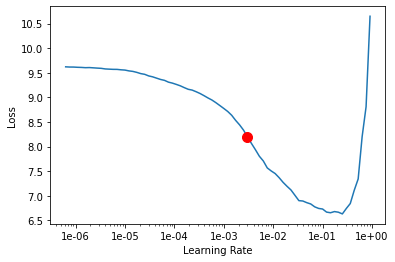

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,1.301264,1.396724,0.771228,0.599676,06:50
1,1.091976,1.122181,0.805851,0.643935,06:53
2,1.015907,1.024305,0.816999,0.659102,06:55
3,0.939511,0.982680,0.823081,0.668167,06:49
4,0.844444,0.935548,0.829528,0.676377,06:44
5,0.802107,0.914766,0.834197,0.683355,06:49
6,0.771146,0.905104,0.836599,0.686924,06:52
7,0.705399,0.907168,0.836969,0.687513,06:55


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.0030199517204020187

In [ ]:
learn.fit_one_cycle(8, min_grad_lr, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,0.689538,0.907336,0.836965,0.687410,06:54
1,0.713210,0.908513,0.836946,0.687407,06:50
2,0.722823,0.907829,0.837057,0.687528,06:54
3,0.730514,0.909097,0.837016,0.687497,06:50
4,0.693890,0.908677,0.837167,0.687730,06:45
5,0.713107,0.908992,0.837135,0.687684,06:48
6,0.676631,0.909049,0.837081,0.687623,06:49
7,0.685861,0.909074,0.837108,0.687652,06:46


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,1.342169,1.411113,0.769959,0.598077,08:56
1,1.054409,1.136466,0.803564,0.641013,09:03
2,1.015723,1.025104,0.816061,0.657839,09:05
3,0.916596,0.971088,0.824248,0.669156,09:06
4,0.859593,0.937243,0.829468,0.676386,09:03
5,0.806224,0.913883,0.834344,0.683541,09:07
6,0.718074,0.904097,0.836522,0.686832,09:04


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:

epoch,train_loss,valid_loss,accuracy,bleu,time
0,1.342169,1.411113,0.769959,0.598077,08:56
1,1.054409,1.136466,0.803564,0.641013,09:03
2,1.015723,1.025104,0.816061,0.657839,09:05
3,0.916596,0.971088,0.824248,0.669156,09:06
4,0.859593,0.937243,0.829468,0.676386,09:03
5,0.806224,0.913883,0.834344,0.683541,09:07
6,0.718074,0.904097,0.836522,0.686832,09:04
7,0.703271,0.905458,0.837294,0.687932,09:10


In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1).cpu()))
    return inputs, targets, outputs

In [ ]:
inputs, targets, outputs = get_predictions(learn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)


In [ ]:
inputs[10], targets[10], outputs[10]

(Text [   2  793   13 1449   13 1449   13    0 4890   13 4890   13 4890   13   55  384   21 1307   13 1307   13 1307   13
   384   34   18   23  292   31   17],
 Text [    2    24    16   920    16   920    16 10926  2986    16  2986    16  2986    16    48   455   120    23  1416
     16  1416    16  1416    16   455    49    32   398    11],
 Text [   2   24   16  920   16  920   16    0   16   16 2986   16 2986   16   48  455   23   23 1416   16 1416   16 1416
    16 1102   49   11  120   11   20])

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(' '.join([learn.data.x.vocab.itos[i] for i in x.cpu()]))
                targets.append(' '.join([learn.data.y.vocab.itos[i] for i in y.cpu()]))
                outputs.append(' '.join([learn.data.y.vocab.itos[i] for i in z.argmax(1).cpu()]))
    return inputs, targets, outputs

In [ ]:
inputs2, tags2, preds2 = get_predictions(learn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)


In [ ]:
inputs2[10], tags2[10], preds2[10]

('xxbos do - o - o - xxunk j - j - j - hanya duduk dan s - s - s - duduk dengan ini di bawah anda !',
 "xxpad xxbos do - o - o - on't j - j - j - just sit down and s - s - s - sit with this under you",
 'xxbos do - o - o - xxunk - - j - j - just sit and and s - s - s - sitting with you down you !')

In [ ]:
inputs[10], targets[10], outputs[10]

(Text [   2  793   13 1449   13 1449   13    0 4890   13 4890   13 4890   13   55  384   21 1307   13 1307   13 1307   13
   384   34   18   23  292   31   17],
 Text [    2    24    16   920    16   920    16 10926  2986    16  2986    16  2986    16    48   455   120    23  1416
     16  1416    16  1416    16   455    49    32   398    11],
 Text [   2   24   16  920   16  920   16    0   16   16 2986   16 2986   16   48  455   23   23 1416   16 1416   16 1416
    16 1102   49   11  120   11   20])

In [ ]:
inputs2[700], tags2[700], preds2[700]

('xxbos aku sudah berada di sini berkali - kali , tapi aku tidak pernah melihat pohon suci di malam hari . xxpad',
 "xxpad xxbos i 've been here many times , but i have never look at sacred tree at night . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",
 "xxbos i 've been here many times , but i 've never seen at the trees in night . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad")

In [ ]:
inputs[701],targets[701],outputs[701]

(Text [   2  225   10  169   45   16   74   31   16   49   27  757  951 1374   31   23  293 1232   10  156   11],
 Text [   2   82   10   25  276   42  140   11   24   22   80   15  615   34 1567 4217   31 1127   10   57   13],
 Text [   2   82   10   25  276   42  140   11   24   22   80   15  615   34 1567  969   31 1127   10   57   13])

In [ ]:
inputs2[2500], tags2[2500], preds2[2500]

('xxbos dia tidak xxunk dia ditikam lebih dari dua lusin kali , ... tepat di sebelah rel',
 'xxpad xxbos he was stabbed more than two dozen times , right next to the tracks . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad',
 "xxbos he did n't him than twice dozen times , right next to the tracks . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad")

In [ ]:
inputs[2500],targets[2500],outputs[2500]

(Text [    2    22    16     0    22  9820    68    36   161 10395   192    10    25   304    23   779  6880],
 Text [   2   33   44 4001  130  178  152 2972  466   10   57  282   15   14 3637    9],
 Text [   2   33   58   22   66  178 1255 2972  466   10   57  282   15   14 3637    9])

In [ ]:
inputs2[4002], tags2[4002], preds2[4002]

('xxbos aku masih mempercayai kalau aku dalam kontrol secara sadar akan tindakan - tindakanku .',
 "xxpad xxbos i still believe i 'm in conscious control of my actions . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",
 "xxbos i still trust i 'm in control control of my actions . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad")

In [ ]:
inputs[4002],targets[4002],outputs[4002]

(Text [    2    12   112  1815   107    12    59  2674   383   814    24  1070    13 11846     9],
 Text [   2   12  159  221   12   39   31 8091  535   25   36 2830    9],
 Text [   2   12  159  384   12   39   31  535  535   25   36 2830    9])

### Label smmothing
They point out in the paper that using label smooting helped getting a better BLEU/accuracy, even it made the loss worse. 

In [ ]:
model = Transformer(len(data.train_ds.x.vocab.itos), 
                    len(data.train_ds.y.vocab.itos), 
                    d_model=256)

In [ ]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))],
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.485038,2.506691,0.775975,0.605187,09:21
1,2.292370,2.301352,0.804368,0.642229,09:26
2,2.161265,2.216744,0.815313,0.656447,09:24
3,2.119617,2.173240,0.823027,0.667531,09:21
4,2.092322,2.133589,0.829954,0.676899,09:22
5,2.012675,2.112217,0.833588,0.682237,09:18
6,1.949033,2.103982,0.836057,0.685932,09:18
7,1.933349,2.104136,0.836504,0.686606,09:27


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:

### Test Leakage

if we cahnge a tocken in the targets at position n, it shouldn't impact the prediction before that

In [ ]:
learn.model.eval();

In [ ]:
xb, yb = data.one_batch(cpu=False)

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
inp1,out1 = xb[0][:1],xb[1][:1]
inp2,out2 = inp1.clone(),out1.clone()
out2[0,15] = 10

In [ ]:
y1 = learn.model(inp1, out1)
y2 = learn.model(inp2, out2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)


In [ ]:
(y1[0,:15] - y2[0,:15]).abs().mean()

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)

## Using DataBlock Methodology 

## RNN 

In [ ]:
emb_enc = torch.load(path + 'id_emb.pth')
emb_dec = torch.load(path + 'en_emb.pth')

In [ ]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [ ]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

In [ ]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [ ]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 15)

In [ ]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

epoch,train_loss,valid_loss,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


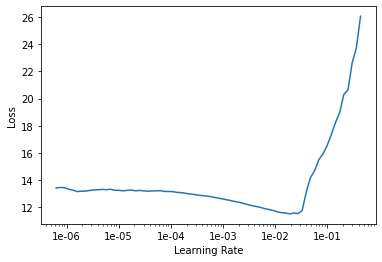

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,time
0,5.324871,5.822594,02:07
1,4.811469,6.055200,02:10
2,4.948428,5.469377,02:12
3,4.842009,5.562602,02:09


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Implementing attention 

In [ ]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

In [ ]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 15)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


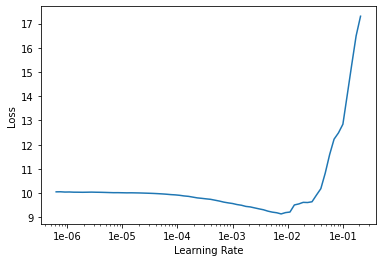

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.015840,4.634838,0.465786,0.345133,04:48
1,3.430456,4.646991,0.458548,0.339659,04:48
2,3.445710,4.229054,0.462651,0.353570,04:49
3,3.353322,4.391807,0.459657,0.360492,04:51
4,3.656444,4.368827,0.462455,0.373086,04:50
5,3.424662,4.113763,0.466647,0.364011,04:47
6,3.434859,3.941239,0.478349,0.365967,04:48
7,3.448818,3.834773,0.474304,0.363953,04:44
8,3.738871,4.440209,0.424739,0.343471,04:45
9,3.211354,3.992463,0.458463,0.346800,04:42


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[1], targets[1], outputs[1]

(Text [   2   12   55   49   14  213  146   76   13   76  356   10   50   14 1514  851  105 4997   87   14  176   23 1960
   175   15 7383  102  134  264    9],
 Text [    2    12    48    80    11    15   154   330  2449   201    10    59    11   923    18  4833    17   776   113
     11    43    31   214    17 15396  1139    25    18   498     9],
 Text [ 2 12 48 80 11 15 48 59 11 15 48 59 18  0 25])

In [ ]:
inputs[701], targets[701], outputs[701]

In [ ]:
inputs[4002], targets[4002], outputs[4002]

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb.cpu(),yb.cpu(),out.cpu()):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb.cpu(),yb.cpu(),out.cpu()):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
learn.model.eval()
inputs, targets, outputs = [],[],[]
with torch.no_grad():
  for xb, yb in progress_bar(learn.dl(DatasetType.Valid)):
    out = learn.model(xb)
    for x,y, z in zip(xb.cpu().numpy(), yb.cpu().numpy(), out.cpu().numpy()):
      inputs.append(learn.data.train_ds.x)
      targets.append(learn.data.train_ds.y)
      #outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
      

In [ ]:
inputs[700]

Seq2SeqTextList (278145 items)
xxbos dan kita harus memiliki gambar dari global hawk 1 sampai,xxbos tidak apa - apa .,xxbos baik , pak .,xxbos hentikan !,xxbos biaya sewa bangunan sama xxunk .
Path: ../../Data/nlp2/en-id.txt

In [ ]:
inputs[100]

Seq2SeqTextList (278145 items)
xxbos dan kita harus memiliki gambar dari global hawk 1 sampai,xxbos tidak apa - apa .,xxbos baik , pak .,xxbos hentikan !,xxbos biaya sewa bangunan sama xxunk .
Path: ../../Data/nlp2/en-id.txt

In [ ]:
targets[1]

Text [    2    12    48    80    11    15   154   330  2449   201    10    59    11   923    18  4833    17   776   113
    11    43    31   214    17 15396  1139    25    18   498     9]

In [ ]:
learn?

In [ ]:
x_ex = [ 2, 12,   44,  176,   23,   60, 4557,   13,  192,   10,   39,   12,   16,   78,   94, 1050, 1465,   23,  118,   85,    9]
target_ex = [ 2,   12,   81,  112,   52,  307,  466,   10,   50,   12,   37,  135,  101,   74, 3047, 1171,   74,  193,    9]
[learn.data.train_ds.x.vocab.itos[i] for i in x_ex]  

['xxbos',
 'aku',
 'sudah',
 'berada',
 'di',
 'sini',
 'berkali',
 '-',
 'kali',
 ',',
 'tapi',
 'aku',
 'tidak',
 'pernah',
 'melihat',
 'pohon',
 'suci',
 'di',
 'malam',
 'hari',
 '.']

In [ ]:
[learn.data.train_ds.y.vocab.itos[i] for i in target_ex] 

['xxbos',
 'i',
 "'ve",
 'been',
 'here',
 'many',
 'times',
 ',',
 'but',
 'i',
 'have',
 'never',
 'look',
 'at',
 'sacred',
 'tree',
 'at',
 'night',
 '.']

In [ ]:
learn.data.train_ds.y.vocab.itos[100]

'when'

In [ ]:
from IPython.display import clear_output

In [ ]:
def get_preds(learn):
    learn.model.eval()
    inputs, targets, outputs = [], [], []

    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(DatasetType.Valid)):
            xb, yb = shift_tfm((xb, yb))
            out = learn.model(*xb)

            for x, y, z in zip(xb[0], xb[1], out):
                inputs.append(x.cpu())
                targets.append(y.cpu())
                outputs.append(z.argmax(1).cpu())

    clear_output()
    
    return inputs, targets, outputs

learn.data.train_ds.y.vocab.itos

In [ ]:
class GetPreds:
    def __init__(self, inputs, preds, targs):
        self.inputs, self.preds, self.targs = inputs, preds, targs

    def get_predictions(self, num, ignore_pad=False): 
        """:ignore_pad: Whether to ignore pad for predictions. Default: False"""
        return (
            itos(dl(DatasetType.Valid).vocab[0], self.inputs[num], join=True, ignore_pad=True),
            itos(dl(DatasetType.Valid).vocab[1], self.targs[num], join=True, ignore_pad=True),
            itos(dl(DatasetType.Valid).vocab[1], self.preds[num], join=True, ignore_pad=ignore_pad)
        )

In [ ]:
print(" ".join([learn.data.train_ds.x.vocab.itos[i] for i in inputs[1]]))
#[learn.data.train_ds.y.vocab.itos[i] for i in inputs[0]]

xxbos aku hanya ingin kau berhenti mengatakan hal - hal aneh , seperti kau mencium ketakutan seorang psikopat atau kau berada di ingatan seseorang yang memudar tentang sebuah kota .


In [ ]:
print(" ".join([learn.data.train_ds.y.vocab.itos[i] for i in targs[1]]))

xxpad xxbos i just want you to stop saying odd shit , like you smell a psycho 's fear or you 're in someone 's faded memory of a town


In [ ]:
print(" ".join([learn.data.train_ds.y.vocab.itos[i] for i in preds[1]]))

xxbos i you just want to just just like you to , i just just


In [ ]:
df[:10]

,en,id
0,"Pretty lucky, huh?","Sungguh beruntung, huh?"
1,Tell me you've taken care of it.,Katakan kau sudah mengurusnya.
2,"Coffee, Mrs. Swann?","Kopi, Ny. Swann?"
3,All you have to do is look at pictures of her ...,Yang harus kau lakukan adalah melihat gambar-n...
4,"Oh, Jesus!","Oh, Yesus!"
5,-Exactly.,-Tepat sekali.
6,"- No, don't.","- Tidak, tidak."
7,I don't know what this documentary's supposed ...,"Aku tidak tahu apa dokumenter ini seharusnya, ..."
8,Being prepared to meet her flock.,Sedang dipersiapkan untuk bertemu dengan pengi...
9,"""Go Ahead and Dream.""","""Go Ahead and Dream."" (Silahkan bermimpi)"


In [ ]:
def shift_tfm(b):
    x, y = b
    y = F.pad(y, (1, 0), value=1)
    return [x, y[:, :-1]], y[:, 1:]

# class ShiftTfm(Transform):
#     def encodes(self, b): return shift_tfm(b)
#     def decodes(self, b): return b

class ShiftTfm(Callback):
    def before_batch(self): 
        self.learn.xb, _ = shift_tfm((self.x, self.y))

In [ ]:
# inputs, preds, targs = learn.get_preds(with_input=True)
inputs, targs, preds = get_preds(learn)
p = GetPreds(inputs, preds, targs)

In [ ]:
p.get_predictions(0)

NameError: ignored

In [ ]:
get_preds(learn)

([tensor([    2,    12,    33,    73,     0,    62,    10,   560,    12,    16,
            177,   489,    36,    46, 13138,  9075,    36,  2467,    19,    10,
             47,  1070,   287,  4157,   220,    98,  1478,    13,     0,     9]),
  tensor([   2,   12,   55,   49,   14,  213,  146,   76,   13,   76,  356,   10,
            50,   14, 1514,  851,  105, 4997,   87,   14,  176,   23, 1960,  175,
            15, 7383,  102,  134,  264,    9]),
  tensor([   2,  514,  146,   22,   16,   24,   78,  487,  295,   19,    9, 3069,
          1050,    0,   81,    0,   10,   21, 9335, 2603,   13, 2603,   15,    0,
            10,   21,  981,   15,    0,    9]),
  tensor([   2,  104,   10,  190,   52,    0,   15, 1507,   10,  904,   13,  904,
          1015,  118,   19,  948,  236,  419, 4130,   21, 4053,    9,   13,   34,
            38,   13, 2609,   10,   62,   12]),
  tensor([   2,   14, 1371,  691,   56,  977,   56,   10,  457,  123,   10,    7,
           187,    9,   40,  112,  167, 

In [ ]:
learn.data.train_ds.y.vocab.itos[2]

'xxbos'

In [ ]:
emb_enc.itos

AttributeError: ignored

In [ ]:
learn.recorder.data.x[2]

Text [  2  42  10 174   9]

In [ ]:
learn.recorder.data.vocab.itos[2]

'xxbos'